### Настройка окружения

In [ ]:
! pip install torchkge -U
!pip install dill

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 2.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 6.6 MB/s eta 0:00:00


In [ ]:
# переходим в нашу директорию
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)
%cd '/content/drive/MyDrive/joie'

Mounted at /content/drive/
/content/drive/MyDrive/joie


In [1]:
# для импорта модулей связанных с joie
import sys
sys.path.insert(0,'joie')

In [2]:
# import torchkge
import torch
from torchkge.data_structures import KnowledgeGraph,SmallKG
import pandas as pd
import numpy as np
from torch import cuda
import gc
from joie.models import *
from joie.evaluation import *
from joie.trainer import *
from joie.utils import *

from torchkge.utils import MarginLoss
from torchkge.models.bilinear import DistMultModel, HolEModel
from torchkge.models.translation import TransEModel
from torchkge.evaluation import LinkPredictionEvaluator

ModuleNotFoundError: ignored

## Загрузка данных

In [ ]:
datasets = {data: 
            {
              type_kg : 
                to_structure_kg(f'data/{data}/{data}_{type_kg}.txt') for type_kg in ['insnet','ontonet','instype']
             } 
            for data in ['db']
          }

Получение тестового и обучающего набора

In [ ]:
kg_insnet_train,kg_insnet_test = train_test_split_kg(datasets['db']['insnet'], test_size=0.1, type_split='size')
kg_ontonet_train,kg_ontonet_test = train_test_split_kg(datasets['db']['ontonet'], test_size=0.5, type_split='size')
kg_instype_train,kg_instype_test = train_test_split_kg(datasets['db']['instype'], test_size=0.1, type_split='size')

### JOIE TransE Cross Groupping

In [ ]:
joie_transe_cg = JOIE(kg_instance = datasets['db']['insnet'], 
                      kg_ontology = datasets['db']['ontonet'], 
                      kg_ins_type = datasets['db']['instype'],
    				entity_dim = 200, concept_dim = 200,
    				intra_view_model = 'transe', cross_view_model = 'cg',
    				margin_intra = 0.5, margin_cross = 0.5,**{'lr_instance':0.0005,'lr_ontology':0.0005,'lr_cross':0.0005})

trainer = TrainerJoie(joie = joie_transe_cg,
                       kg_instance = datasets['db']['insnet'],
                       kg_ontology = datasets['db']['ontonet'],  
                       kg_instype = datasets['db']['instype'],
        n_epochs = 100, n_batches = 300,alpha = 1, omega = 1,sampling_type='bern', use_cuda='all')


  0%|          | 0/100 [00:00<?, ?epoch/s]

28

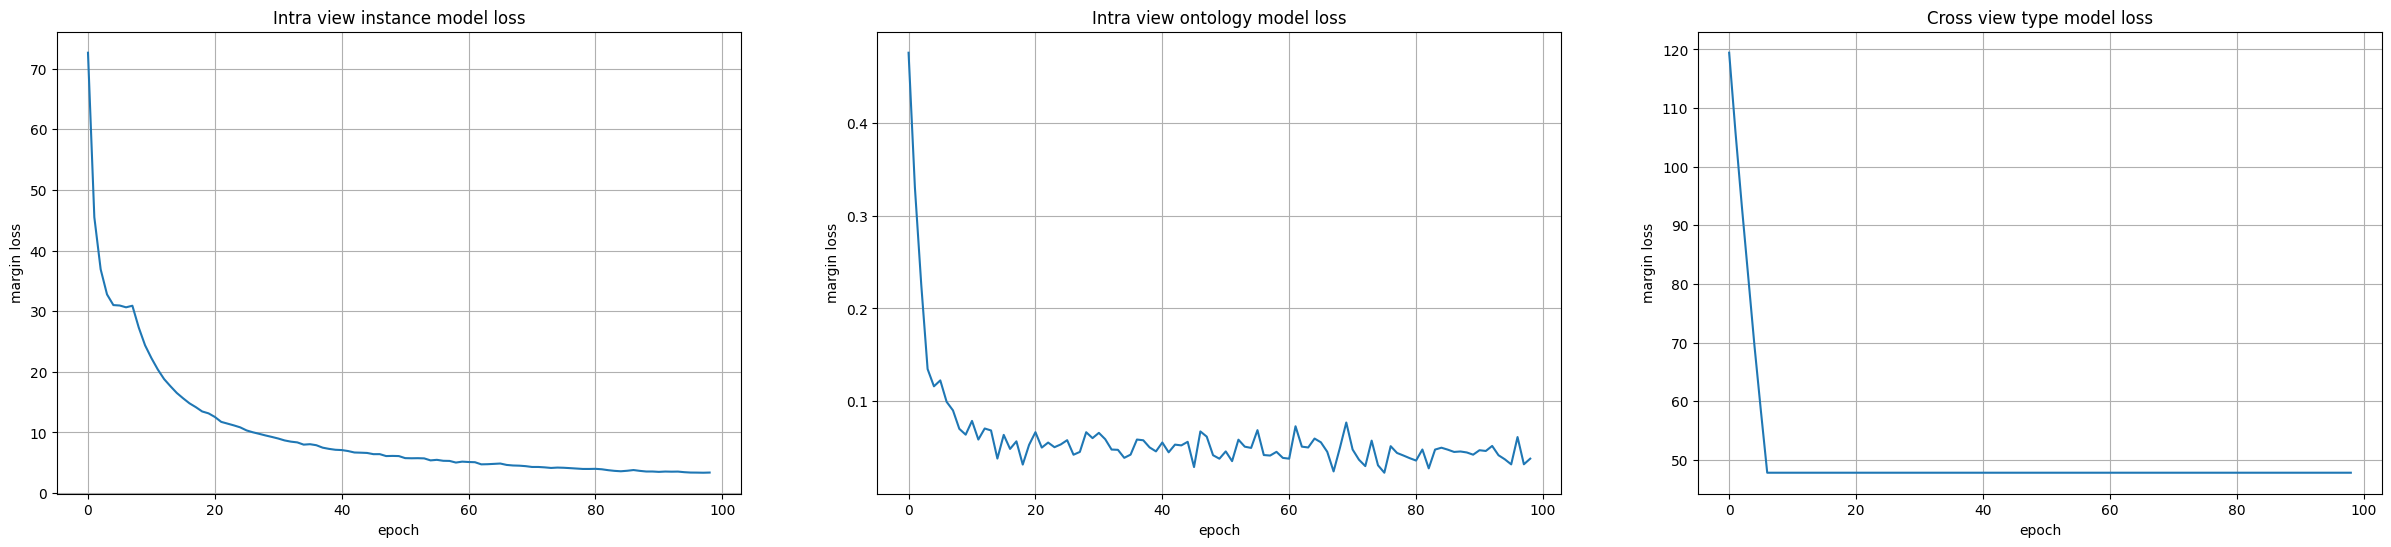

In [ ]:
trainer.run(50)
trainer.plot_train_process()
torch.cuda.empty_cache()
gc.collect()

In [ ]:
results_transe = joie_transe_cg.joie_performance(kg_insnet_test,
                                             kg_ontonet_test,
                                             kg_instype_test,64,100)

KG instance: Link prediction evaluation:   0%|          | 0/1029 [00:00<?, ?batch/s]

KG ontology: Link prediction evaluation:   0%|          | 0/5 [00:00<?, ?batch/s]

Cross evaluation:   0%|          | 0/105 [00:00<?, ?batch/s]

In [ ]:
results_transe

{'instance': {'mrr': (0.3493698239326477, 0.4145975410938263),
  'hit_at_1': (0.15647312998771667, 0.19632060825824738),
  'hit_at_3': (0.46712544560432434, 0.583447277545929),
  'hit_at_10': (0.7260960936546326, 0.7583629488945007),
  'evaluator': <evaluation.JoieLinkPredictionEvaluator at 0x7f6825ec4a60>},
 'ontology': {'mrr': (0.5220739245414734, 0.604823112487793),
  'hit_at_1': (0.26838234066963196, 0.3125),
  'hit_at_3': (0.7352941036224365, 0.8933823704719543),
  'hit_at_10': (0.9816176295280457, 1.0),
  'evaluator': <evaluation.JoieLinkPredictionEvaluator at 0x7f6825de44f0>},
 'type': {'mrr': 0.9849613904953003,
  'hit_at_1': 0.9752920269966125,
  'hit_at_3': 0.9938604235649109,
  'evaluator': <evaluation.CrossEvaluator at 0x7f6825de6890>}}

### JOIE DistMult Cross Groupping

In [ ]:
joie_distmult_cg = JOIE(kg_instance = datasets['db']['insnet'], 
                        kg_ontology = datasets['db']['ontonet'], 
                        kg_ins_type = datasets['db']['instype'],
    				entity_dim = 200, concept_dim = 200,
    				intra_view_model = 'distmult', cross_view_model = 'cg',
    				margin_intra = 1, margin_cross = 1,**{'lr_instance':0.0005,'lr_ontology':0.0005,'lr_cross':0.0005})

trainer = TrainerJoie(joie = joie_distmult_cg,
                       kg_instance = datasets['db']['insnet'],
                       kg_ontology = datasets['db']['ontonet'],  
                       kg_instype = datasets['db']['instype'],
        n_epochs = 100, n_batches = 300,alpha = 1, omega = 1,sampling_type='bern', use_cuda='all')


  0%|          | 0/100 [00:00<?, ?epoch/s]

0

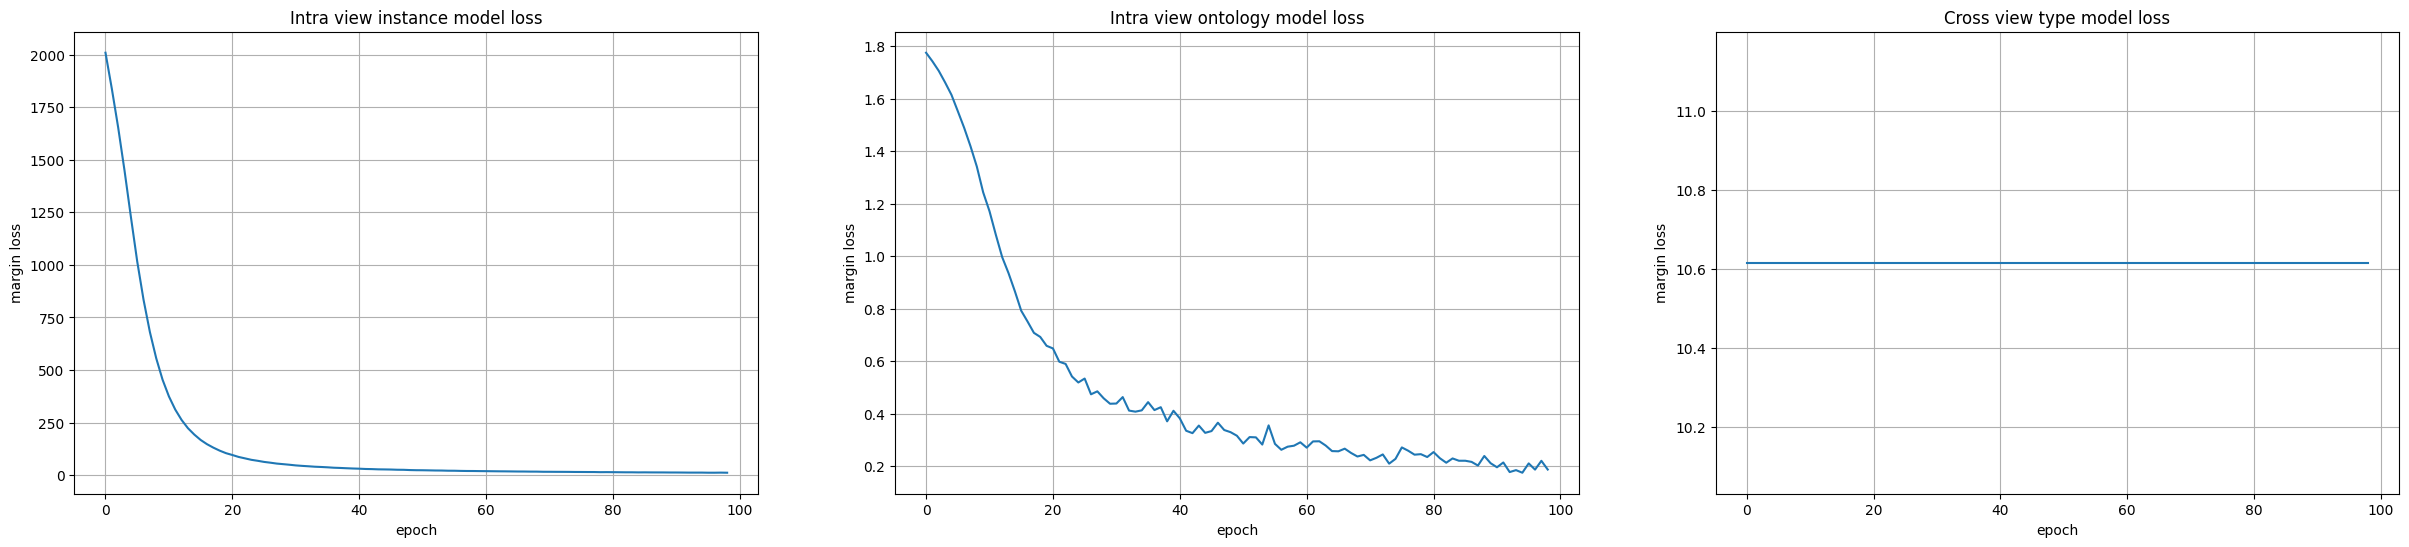

In [ ]:
trainer.run(50)
trainer.plot_train_process()
torch.cuda.empty_cache()
gc.collect()

In [ ]:
results_distmult = joie_distmult_cg.joie_performance(kg_insnet_test,
                                             kg_ontonet_test,
                                             kg_instype_test,2048,4096)
results_distmult

KG instance: Link prediction evaluation:   0%|          | 0/33 [00:00<?, ?batch/s]

KG ontology: Link prediction evaluation:   0%|          | 0/1 [00:00<?, ?batch/s]

Cross evaluation:   0%|          | 0/4 [00:00<?, ?batch/s]

{'instance': {'mrr': (0.3882228136062622, 0.4416184425354004),
  'hit_at_1': (0.23226384818553925, 0.28405189514160156),
  'hit_at_3': (0.46537843346595764, 0.5339531302452087),
  'hit_at_10': (0.7030960321426392, 0.7337374091148376),
  'evaluator': <evaluation.JoieLinkPredictionEvaluator at 0x7f6846b02170>},
 'ontology': {'mrr': (0.5704123377799988, 0.6514078378677368),
  'hit_at_1': (0.375, 0.4375),
  'hit_at_3': (0.7242646813392639, 0.8272058963775635),
  'hit_at_10': (0.9448529481887817, 0.9816176295280457),
  'evaluator': <evaluation.JoieLinkPredictionEvaluator at 0x7f690bf77d60>},
 'type': {'mrr': 0.9290856719017029,
  'hit_at_1': 0.887990415096283,
  'hit_at_3': 0.9672057628631592,
  'evaluator': <evaluation.CrossEvaluator at 0x7f68424a9300>}}

### JOIE Hole Cross Groupping

In [ ]:
joie_hole_cg = JOIE(kg_instance = datasets['db']['insnet'], 
                    kg_ontology = datasets['db']['ontonet'], 
                    kg_ins_type = datasets['db']['instype'],
    				entity_dim = 200, concept_dim = 200,
    				intra_view_model = 'hole', cross_view_model = 'cg',
    				margin_intra = 1, margin_cross = 1,**{'lr_instance':0.0005,'lr_ontology':0.0005,'lr_cross':0.0005})

trainer = TrainerJoie(joie = joie_hole_cg,
                       kg_instance = datasets['db']['insnet'],
                       kg_ontology = datasets['db']['ontonet'], 
                       kg_instype = datasets['db']['instype'],
        n_epochs = 40, n_batches = 300,alpha = 1, omega = 1,sampling_type='bern', use_cuda='all')


  0%|          | 0/40 [00:00<?, ?epoch/s]

0

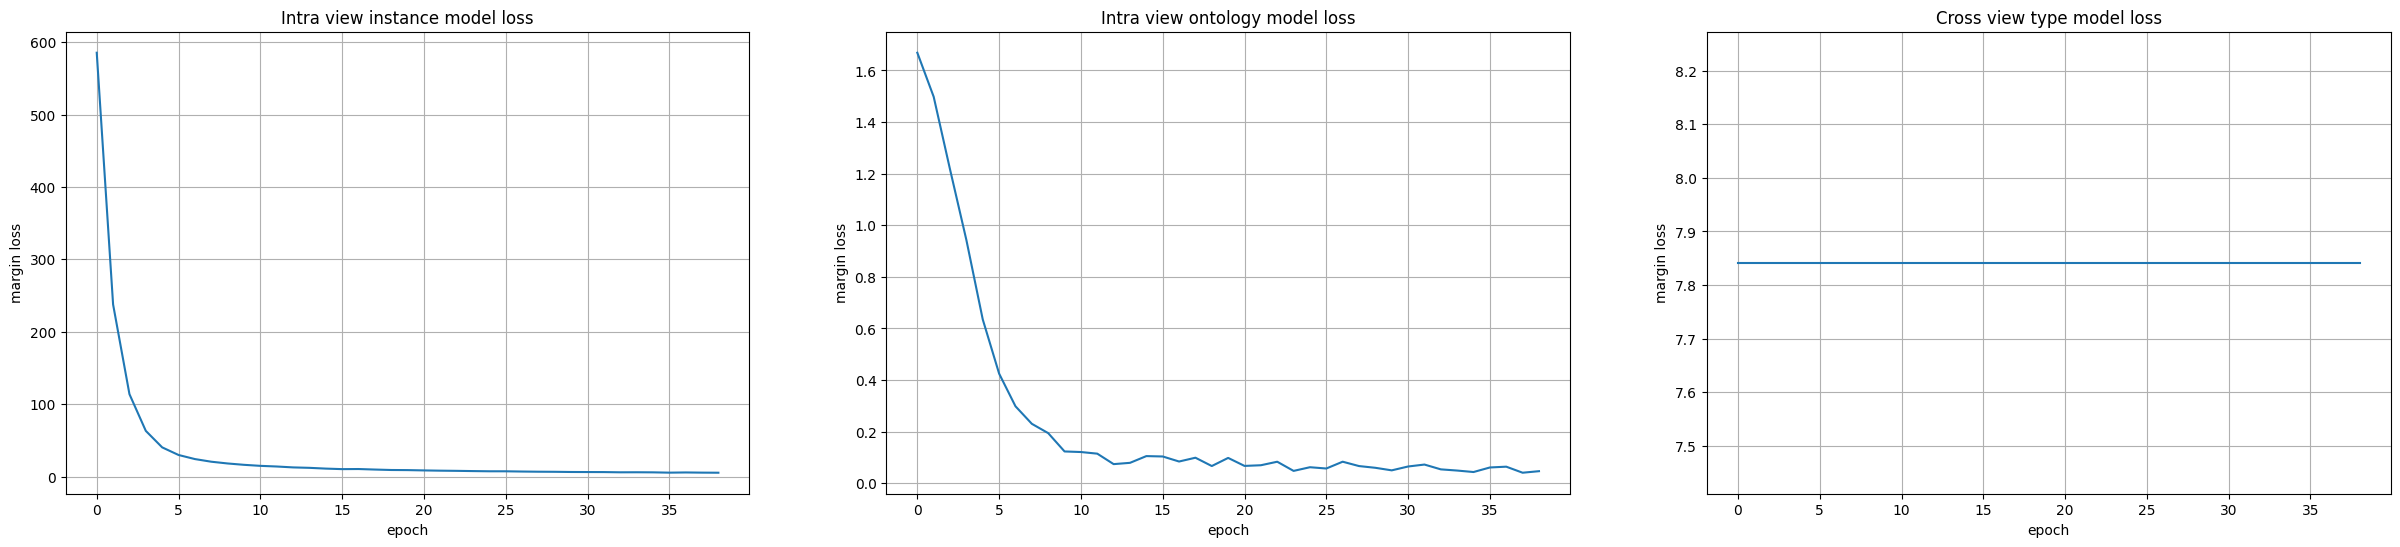

In [ ]:
trainer.run(100)
trainer.plot_train_process()
torch.cuda.empty_cache()
gc.collect()

In [ ]:
results_hole = joie_hole_cg.joie_performance(kg_insnet_test,
                                             kg_ontonet_test,
                                             kg_instype_test,1028,4096)

results_hole

KG instance: Link prediction evaluation:   0%|          | 0/44 [00:00<?, ?batch/s]

KG ontology: Link prediction evaluation:   0%|          | 0/1 [00:00<?, ?batch/s]

Cross evaluation:   0%|          | 0/5 [00:00<?, ?batch/s]

{'instance': {'mrr': (0.4231854975223541, 0.4963676631450653),
  'hit_at_1': (0.2916173040866852, 0.3837997019290924),
  'hit_at_3': (0.4869200587272644, 0.5515905618667603),
  'hit_at_10': (0.6836356520652771, 0.7148239016532898),
  'evaluator': <evaluation.JoieLinkPredictionEvaluator at 0x7f6823bddc30>},
 'ontology': {'mrr': (0.7380674481391907, 0.9426207542419434),
  'hit_at_1': (0.591911792755127, 0.8970588445663452),
  'hit_at_3': (0.8492646813392639, 0.9926470518112183),
  'hit_at_10': (0.9889705777168274, 1.0),
  'evaluator': <evaluation.JoieLinkPredictionEvaluator at 0x7f684720bcd0>},
 'type': {'mrr': 0.8602085709571838,
  'hit_at_1': 0.821054220199585,
  'hit_at_3': 0.8793051838874817,
  'evaluator': <evaluation.CrossEvaluator at 0x7f6823bdcfa0>}}

### JOIE Complex Cross Groupping

In [ ]:
joie_complex_cg = JOIE(kg_instance = datasets['db']['insnet'], 
                    kg_ontology = datasets['db']['ontonet'], 
                    kg_ins_type = datasets['db']['instype'],
    				entity_dim = 200, concept_dim = 200,
    				intra_view_model = 'complex', cross_view_model = 'cg',
    				margin_intra = 1, margin_cross = 1,**{'lr_instance':0.0005,'lr_ontology':0.0005,'lr_cross':0.0005})

trainer = TrainerJoie(joie = joie_complex_cg,
                       kg_instance = datasets['db']['insnet'],
                       kg_ontology = datasets['db']['ontonet'],  
                       kg_instype = datasets['db']['instype'],
        n_epochs = 40, n_batches = 300,alpha = 1, omega = 1,sampling_type='bern', use_cuda='all')


  0%|          | 0/40 [00:00<?, ?epoch/s]

32

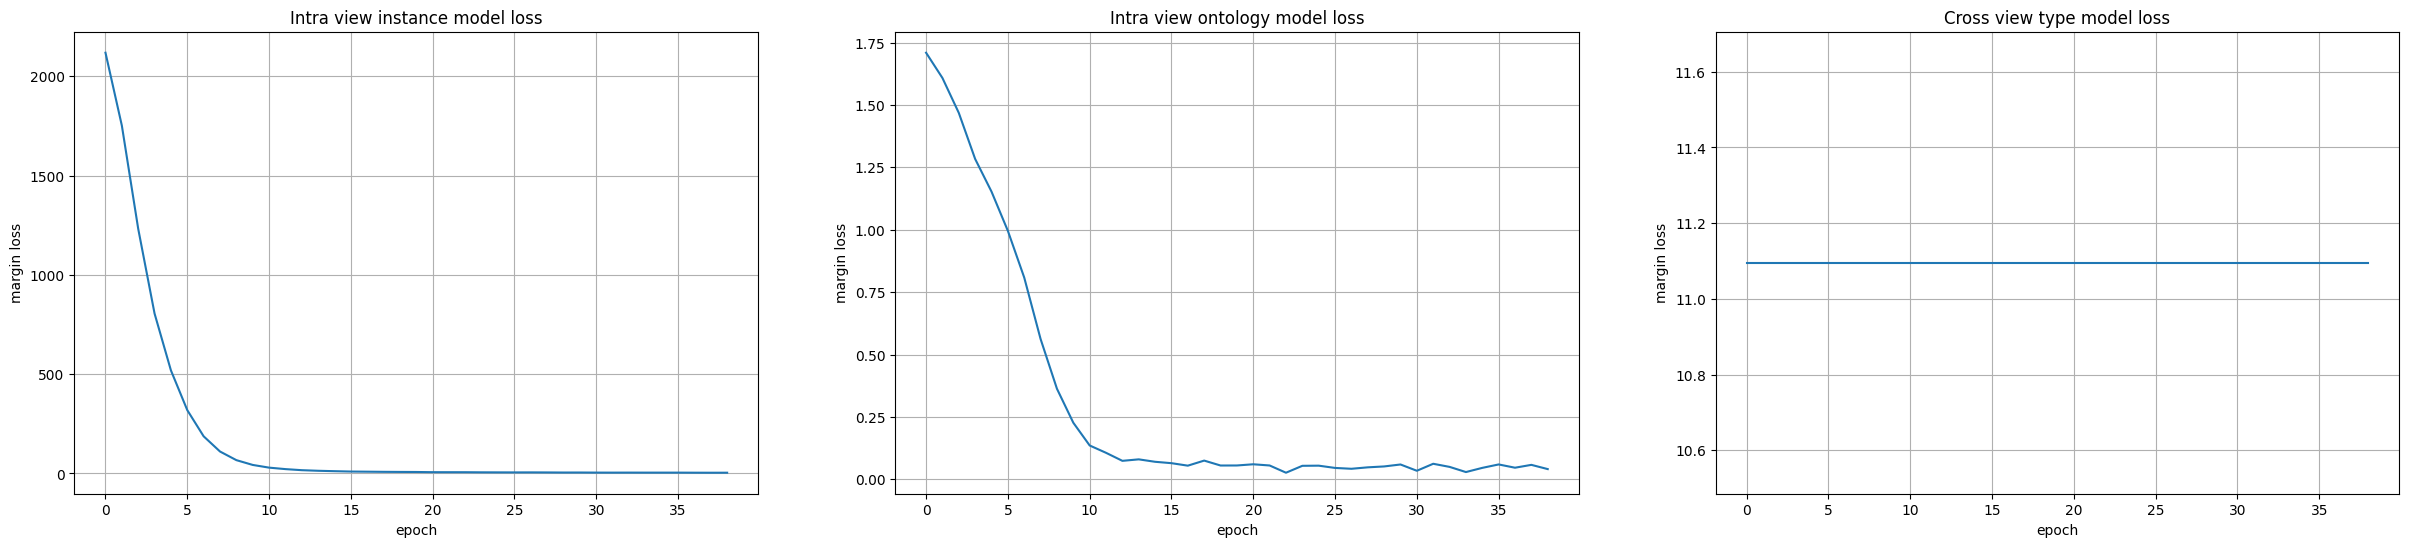

In [ ]:
trainer.run(100)
trainer.plot_train_process()
torch.cuda.empty_cache()
gc.collect()

In [ ]:
results_complex = joie_complex_cg.joie_performance(kg_insnet_test,
                                             kg_ontonet_test,
                                             kg_instype_test,512,2048)
results_complex

KG instance: Link prediction evaluation:   0%|          | 0/129 [00:00<?, ?batch/s]

KG ontology: Link prediction evaluation:   0%|          | 0/1 [00:00<?, ?batch/s]

Cross evaluation:   0%|          | 0/14 [00:00<?, ?batch/s]

{'instance': {'mrr': (0.45284929871559143, 0.5465922951698303),
  'hit_at_1': (0.3003828227519989, 0.41404610872268677),
  'hit_at_3': (0.533801257610321, 0.625315248966217),
  'hit_at_10': (0.7603226900100708, 0.7955518960952759),
  'evaluator': <evaluation.JoieLinkPredictionEvaluator at 0x7f6846b03d30>},
 'ontology': {'mrr': (0.7442460656166077, 0.9889705777168274),
  'hit_at_1': (0.6029411554336548, 0.9779411554336548),
  'hit_at_3': (0.875, 1.0),
  'hit_at_10': (0.9963235259056091, 1.0),
  'evaluator': <evaluation.JoieLinkPredictionEvaluator at 0x7f6825dd1a80>},
 'type': {'mrr': 0.27132588624954224,
  'hit_at_1': 0.1184486374258995,
  'hit_at_3': 0.34606170654296875,
  'evaluator': <evaluation.CrossEvaluator at 0x7f6846b02590>}}

In [ ]:
torch.cuda.empty_cache()

In [ ]:
gc.collect()